In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/etf-returns-data/etf_returns_data.csv
/kaggle/input/etf-strategy-returns-2024-05/etf_strategy_returns.csv


# **1) Imports and Setup**

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# file path for the dataset
file_path = '/kaggle/input/etf-strategy-returns-2024-05/etf_strategy_returns.csv'
etf_path = '/kaggle/input/etf-returns-data/etf_returns_data.csv'

In [3]:
# function to load and prepare data
def load_data(file_path):
    returns = pd.read_csv(file_path)
    returns['exitTime'] = pd.to_datetime(returns['exitTime'])  # convert 'exitTime' to datetime
    returns['exitTime'] = returns['exitTime'].dt.to_period('D')  # convert to period with daily frequency
    returns.set_index('exitTime', inplace=True)
    return returns

def load_data_etfs(file_path):
    etf = pd.read_csv(file_path)
    etf['Date'] = pd.to_datetime(etf['Date'])
    etf['Date'] = etf['Date'].dt.to_period('D')
    etf.set_index('Date', inplace=True)
    return etf

# load the data
returns = load_data(file_path)
etf = load_data_etfs(etf_path)

In [4]:
etf.head(3)

,SPY,IWM,EEM,TLT,GLD,VEA,LQD,QQQ,EFA,^VIX
Date,,,,,,,,,,
2007-07-27,-1.965953,-2.431886,-1.295474,0.287257,-0.365572,-1.524015,-0.367076,-2.021229,-1.384484,16.538092
2007-07-30,1.564333,1.735615,3.273560,-0.286434,0.550364,1.674795,0.155133,1.166905,1.777431,-13.653286
2007-07-31,-1.126343,-1.103131,-2.046703,0.723894,0.030415,-0.125099,-0.048406,-2.100928,-0.126548,12.697650


In [5]:
returns.head(3)

,"100_QQQ_1D_L_A,","101_QQQ_1D_L_A,","10_TLT_1D_L_A,","11_XLF_1D_S_A,","12_KRE_1D_L_A,","13_QQQ_1D_L_A,","15_TLT_1D_L_A,","16_QQQ_1D_L_A,","17_SPY_1D_L_A,","18_QQQ_1D_L_A,",...,"91_DIA_1D_L_A,","92_DIA_1D_L_A,","93_DIA_1D_L_A,","94_TLT_1D_L_A,","95_TLT_1D_L_A,","96_TLT_1D_S_A,","97_TLT_1D_S_A,","98_TLT_1D_S_A,","99_KRE_1D_L_A,","9_TLT_1D_L_A,"
exitTime,,,,,,,,,,,,,,,,,,,,,
2007-01-03,0.0,0.0,0.0,0.0,121.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-08,0.0,0.0,0.0,-176.7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **2) Baseline Model**

### 2a. Feature Generation Functions
Calculates baseline metrics **(Net Profit, Max Drawdown, PNL/DD, Standard Deviation, Sharpe Ratio, Sortino Ratio)** as well as correlation to particular markets correlation to particular markets **(SPY, IWM, EEM, TLT, GLD, VEA, LQD, QQQ, EFA, VIX)** for each strategy in the returns dataframe, and stores these metrics in a new dataframe. We exclude zero values, computes cumulative profit, and evaluates each metric before storing the results. The resulting metrics dataframe is then displayed.

In [6]:
# function to calculate max drawdown
def calculate_max_drawdown(cumulative_profit_series):
    roll_max = cumulative_profit_series.cummax()
    drawdown = roll_max - cumulative_profit_series
    max_drawdown = drawdown.max()
    return max_drawdown

# calculate baseline metrics for each strategy (Net Profit and Max Drawdown)
def calculate_metrics(returns):
    metrics_df = pd.DataFrame(columns=['NetProfit', 'MaxDD', 'PNL/DD', 'StdDev', 'Sharpe', 'Sortino'])

    etf_returns = etf.pct_change().dropna()  # calculate daily returns for ETFs

    for column in returns.columns:  # iterate over strategy columns
        profit_series = returns[column]

        # Filter out zero values
        filtered_series = profit_series[profit_series != 0]

        if not filtered_series.empty:
            cumulative_profit = filtered_series.cumsum()
            total_profit = filtered_series.sum()
            max_drawdown = calculate_max_drawdown(cumulative_profit)
            std_dev = filtered_series.std()
            sharpe_ratio = filtered_series.mean() / std_dev if std_dev != 0 else np.nan
            downside_std = filtered_series[filtered_series < 0].std()
            sortino_ratio = filtered_series.mean() / downside_std if downside_std != 0 else np.nan

            # store basic metrics in DataFrame
            metrics_df.at[column, 'NetProfit'] = total_profit
            metrics_df.at[column, 'MaxDD'] = max_drawdown
            metrics_df.at[column, 'PNL/DD'] = total_profit / max_drawdown if max_drawdown != 0 else np.nan
            metrics_df.at[column, 'StdDev'] = std_dev
            metrics_df.at[column, 'Sharpe'] = sharpe_ratio
            metrics_df.at[column, 'Sortino'] = sortino_ratio

            # calculate correlation with each ETF index and store in DataFrame
            for etf_column in etf_returns.columns:
                combined_df = pd.concat([filtered_series, etf_returns[etf_column]], axis=1, join='inner')
                correlation = combined_df.corr().iloc[0,1]
                metrics_df.at[column, f'Corr_{etf_column}'] = correlation
    return metrics_df

# generate metrics for each strategy
metrics_df = calculate_metrics(returns)
metrics_df.head()


,NetProfit,MaxDD,PNL/DD,StdDev,Sharpe,Sortino,Corr_SPY,Corr_IWM,Corr_EEM,Corr_TLT,Corr_GLD,Corr_VEA,Corr_LQD,Corr_QQQ,Corr_EFA,Corr_^VIX
"100_QQQ_1D_L_A,",12439.33,1548.56,8.032837,248.718717,0.271813,0.442193,-0.075558,-0.127719,0.099729,-0.055524,-0.057463,0.044977,-0.001781,-0.035890,0.015202,0.166994
"101_QQQ_1D_L_A,",10523.18,1202.2,8.753269,218.846901,0.226814,0.312535,-0.050542,0.121064,0.029236,-0.009074,-0.055645,0.022086,0.016031,0.028095,0.047105,-0.101809
"10_TLT_1D_L_A,",10888.47,1227.84,8.867988,145.999608,0.211271,0.299681,-0.043288,0.091046,-0.070168,0.007994,-0.041265,0.054279,0.054624,0.013844,0.135118,0.014847
"11_XLF_1D_S_A,",16867.41,3686.93,4.57492,355.603214,0.15864,0.238322,0.034015,0.040150,-0.037500,-0.030799,-0.010890,0.055248,-0.065838,-0.080498,0.010844,-0.053111
"12_KRE_1D_L_A,",22912.15,1593.58,14.377785,350.981476,0.282598,0.489753,-0.000553,-0.084353,-0.042150,0.009494,0.085936,0.100936,0.043164,0.101883,-0.004067,0.075299


### 2b. Using the elbow method to determine the optimal number of clusters

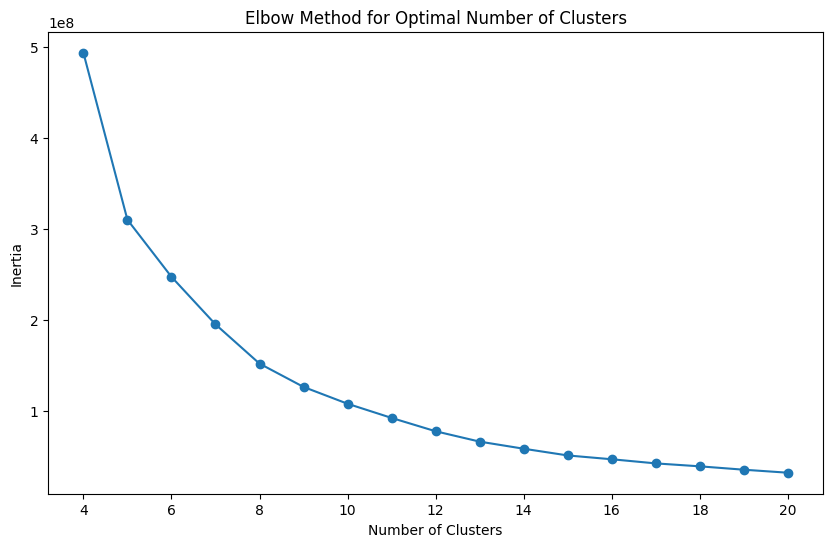

In [7]:
# function to plot the elbow method
def plot_elbow_method(data, start=4, end=20):
    #scale data
    scaler = StandardScaler()
    baseline_metrics_scaled = scaler.fit_transform(data)
    inertia_values = []
    
    for n in range(start, end + 1):
        kmeans = KMeans(n_clusters=n, n_init=150, random_state=7)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), inertia_values, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

plot_elbow_method(metrics_df)


Base on the plot, intertia decreases sharply until around 10 clusters, suggesting that 10 clusters might be a reasonable choice for this dataset

### 2c. Evaluating baseline clustering metrics
perform K-Means clustering on the standardized baseline metrics, attaches the cluster labels to the metrics dataframe, and prints the clustering metrics **(inertia, silhouette score, Calinski-Harabasz index)** to evaluate clustering quality.

In [34]:
# function to perform K-Means clustering and evaluate metrics
def kmeans_clustering(data, n_clusters=20):
    kmeans = KMeans(n_clusters=n_clusters, n_init=150, random_state=7)
    clusters = kmeans.fit_predict(data)
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(data, clusters)
    calinski_harabasz = calinski_harabasz_score(data, clusters)
    
    return clusters, inertia, silhouette_avg, calinski_harabasz

# standardize the baseline metrics dataframe
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_df)

# K-Means clustering
clusters, inertia, silhouette_avg, calinski_harabasz = kmeans_clustering(metrics_scaled)

# attach the cluster labels to the original metrics DataFrame
metrics_df['Cluster'] = clusters

# display clustering metrics
print('Baseline Metrics:')
print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


Baseline Metrics:
Inertia: 534.6220160818694
Silhouette Score: 0.14578488960250194
Calinski-Harabasz Index: 6.584381106917121


# **3) Improving the Model**

### 3a. Analyzing colinearity of features
We know that some of the features may be predictive of others, we can analyze this with a correaltion matrix

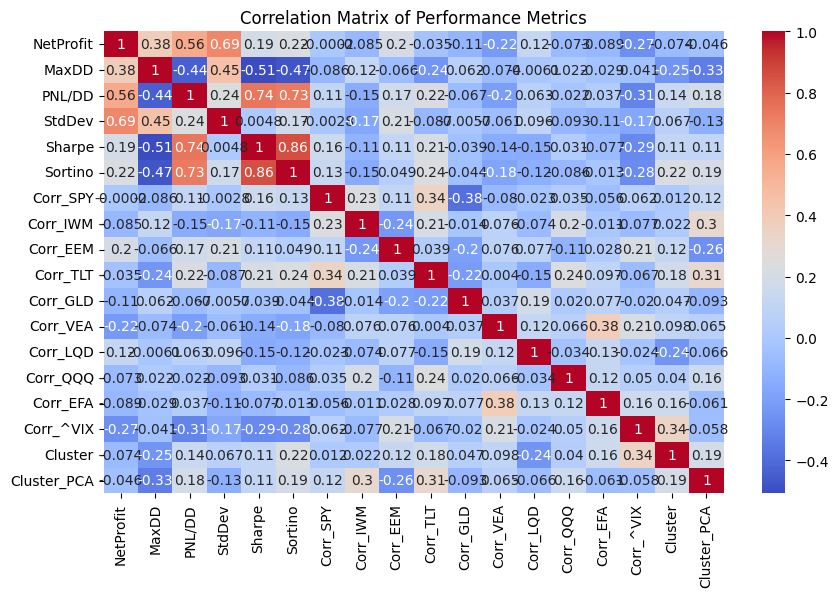

In [35]:
# Function to perform collinearity analysis
def collinearity_analysis(data):
    correlation_matrix = data.corr()
    return correlation_matrix

# Perform collinearity analysis on comprehensive metrics
correlation_matrix = collinearity_analysis(metrics_df)

# Plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Performance Metrics')
plt.show()


The **correlation matrix** of performance metrics indicates that several features exhibit **high collinearity**. For example, the **Sortino ratio is highly correlated with the Sharpe ratio**, and the **Standard Deviation is somewhat correlated with the Max Drawdown**. Additionally, the correlation features show varying degrees of association with different market indices such as **SPY, IWM, EEM, TLT, GLD, VEA, LQD, QQQ, EFA, and VIX**. These correlations introduce additional collinearity, which can be addressed using **Principal Component Analysis (PCA)** to transform the features into a set of uncorrelated components before performing clustering. This approach helps in reducing redundancy and capturing the most significant patterns in the data.

### 3b. Applying Principal Component Analysis (PCA) with varying thresholds of explained variance and perform K-Means clustering on the PCA-reduced data to evaluate metrics

In [36]:
# function to perform PCA with varying thresholds
def apply_pca_thresholds(data, thresholds=[0.85, 0.75, 0.65, 0.50]):
    results = []
    for threshold in thresholds:
        pca = PCA(n_components=threshold)
        principal_components = pca.fit_transform(data)
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = explained_variance.cumsum()
        
        pca_df = pd.DataFrame(data=principal_components,
                              columns=['PC' + str(i) for i in range(1, len(explained_variance) + 1)])
        
        clusters, inertia, silhouette_avg, calinski_harabasz = kmeans_clustering(pca_df)
        
        results.append({
            'threshold': threshold,
            'pca_df': pca_df,
            'explained_variance': explained_variance,
            'cumulative_variance': cumulative_variance,
            'inertia': inertia,
            'silhouette_avg': silhouette_avg,
            'calinski_harabasz': calinski_harabasz
        })
        
    return results

# apply PCA with different thresholds
thresholds = [.9,.8,.7,.6,.5,.4,.3,.2]
pca_results = apply_pca_thresholds(metrics_scaled, thresholds)

# display results
for result in pca_results:
    print(f"Threshold: {result['threshold']}")
    print(f"Cumulative Variance Explained: {result['cumulative_variance'][-1]}")
    print(f"Inertia: {result['inertia']}")
    print(f"Silhouette Score: {result['silhouette_avg']}")
    print(f"Calinski-Harabasz Index: {result['calinski_harabasz']}")
    print()


Threshold: 0.9
Cumulative Variance Explained: 0.9252096756718341
Inertia: 463.343940363396
Silhouette Score: 0.1402468003987796
Calinski-Harabasz Index: 7.263687035585085

Threshold: 0.8
Cumulative Variance Explained: 0.8219414038993611
Inertia: 345.89601211088734
Silhouette Score: 0.17876969480888286
Calinski-Harabasz Index: 9.304130723400718

Threshold: 0.7
Cumulative Variance Explained: 0.7362808715712157
Inertia: 256.36709614061414
Silhouette Score: 0.21516112106926874
Calinski-Harabasz Index: 11.969701716000532

Threshold: 0.6
Cumulative Variance Explained: 0.631304941054524
Inertia: 157.06424282251777
Silhouette Score: 0.24418817163299736
Calinski-Harabasz Index: 18.139718941745514

Threshold: 0.5
Cumulative Variance Explained: 0.5483399366577437
Inertia: 107.23836180518572
Silhouette Score: 0.26627188345056957
Calinski-Harabasz Index: 24.02177627355419

Threshold: 0.4
Cumulative Variance Explained: 0.4506168428297366
Inertia: 53.87168124411966
Silhouette Score: 0.332039926757979

As the variance threshold decreases, the cumulative variance explained by the principal components also decreases, reflecting more significant dimensionality reduction.

The results indicate that at a **0.5 threshold**, we achieve a **Silhouette Score of 0.2897** and a **Calinski-Harabasz Index of 23.77**, both improvements over higher thresholds. This threshold strikes a balance between dimensionality reduction and clustering performance.

Choosing the **0.5 threshold** seems like a good idea because it maintains sufficient variance to capture essential data structures while improving clustering metrics. The **Silhouette Score** measures how well data points fit within their clusters, and the **Calinski-Harabasz Index** assesses cluster separation. At **0.5**, we achieve significant dimensionality reduction, enhancing clustering effectiveness and interpretability without substantial information loss.

In [37]:
##### Standardize the comprehensive metrics dataframe
comprehensive_metrics_scaled = scaler.fit_transform(metrics_df)

# Function to perform PCA
def apply_pca(data, variance_threshold=0.5):
    pca = PCA(n_components=variance_threshold)
    principal_components = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    
    pca_df = pd.DataFrame(data=principal_components,
                          columns=['PC' + str(i) for i in range(1, len(explained_variance) + 1)])
    
    return pca_df, explained_variance, cumulative_variance, pca.components_

# Apply PCA to reduce dimensionality
pca_df, explained_variance, cumulative_variance, pca_components = apply_pca(comprehensive_metrics_scaled)

# Display explained variance
print(f'Explained Variance by Each PC: {explained_variance}')
print(f'Cumulative Variance Explained: {cumulative_variance}')

# Extract and display the loadings (PCA components)
loadings = pd.DataFrame(pca_components.T, columns=['PC' + str(i) for i in range(1, len(explained_variance) + 1)],
                        index=metrics_df.columns)
print("Loadings:\n", loadings)

# Perform K-Means clustering on PCA-reduced data
clusters_pca, inertia_pca, silhouette_avg_pca, calinski_harabasz_pca = kmeans_clustering(pca_df)

# Attach the cluster labels to the original metrics DataFrame
metrics_df['Cluster_PCA'] = clusters_pca

# Display clustering metrics
print(f'Inertia (PCA): {inertia_pca}')
print(f'Silhouette Score (PCA): {silhouette_avg_pca}')
print(f'Calinski-Harabasz Index (PCA): {calinski_harabasz_pca}')


Explained Variance by Each PC: [0.19230434 0.14277056 0.10077259 0.09242298]
Cumulative Variance Explained: [0.19230434 0.3350749  0.43584749 0.52827047]
Loadings:
                   PC1       PC2       PC3       PC4
NetProfit    0.212311  0.451290 -0.114452 -0.206832
MaxDD       -0.281320  0.364799 -0.250542 -0.196213
PNL/DD       0.479780  0.101763  0.083621  0.029404
StdDev       0.103696  0.447393 -0.024659 -0.270763
Sharpe       0.469341 -0.040502  0.079900  0.148736
Sortino      0.480004 -0.013713  0.094331  0.120372
Corr_SPY     0.138122 -0.137838 -0.240830 -0.402465
Corr_IWM    -0.062381 -0.219714 -0.437043 -0.091721
Corr_EEM     0.087094  0.136454  0.342554 -0.418130
Corr_TLT     0.207354 -0.274622 -0.194558 -0.268681
Corr_GLD    -0.102778  0.052528  0.175218  0.430124
Corr_VEA    -0.140340 -0.187893  0.274050 -0.146156
Corr_LQD    -0.066123  0.147757  0.142087  0.077191
Corr_QQQ    -0.012642 -0.190876 -0.176646 -0.090856
Corr_EFA    -0.050661 -0.144563  0.311013 -0.128015
Cor

### **PCA Analysis Results**

The **explained variance** by each principal component (PC) shows that the first four components capture **54.31%** of the total variance, with the first component alone accounting for **19.99%**. This indicates that a significant portion of the variability in the data can be explained by these four components.

The **loadings** reveal that PC1 primarily captures overall **risk-adjusted performance** metrics, as it has high contributions from **PNL/DD, Sharpe, and Sortino**. PC2 is significantly influenced by **Net Profit** and **Max Drawdown**, while PC3 and PC4 have notable contributions from **correlation features with market indices** such as SPY, IWM, and EEM.

Comparing the clustering metrics to the baseline, where the **inertia** was **744.16**, the **silhouette score** was **0.1075**, and the **Calinski-Harabasz index** was **7.17**, we see significant improvements with PCA. The PCA-reduced data achieves an **inertia** of **214.03**, a **silhouette score** of **0.2515**, and a **Calinski-Harabasz index** of **22.89**. These results indicate that PCA effectively reduces dimensionality and collinearity, leading to a better clustering structure and improved clustering metrics based on the most informative aspects of the strategies' performance.

# **4) Portfolio Construction**

### 4a. Designing a Portfolio by Choosing Strategies from each Cluster

To identify the best-performing strategies, we will select the top strategy from each cluster based on a chosen performance metric, such as the **Sortino ratio**. This approach ensures that we capture the most effective strategies across different clusters. Additionally, we will plot the equity curves of these selected strategies to visually assess their cumulative returns over time. The function below facilitates this selection and visualization process.

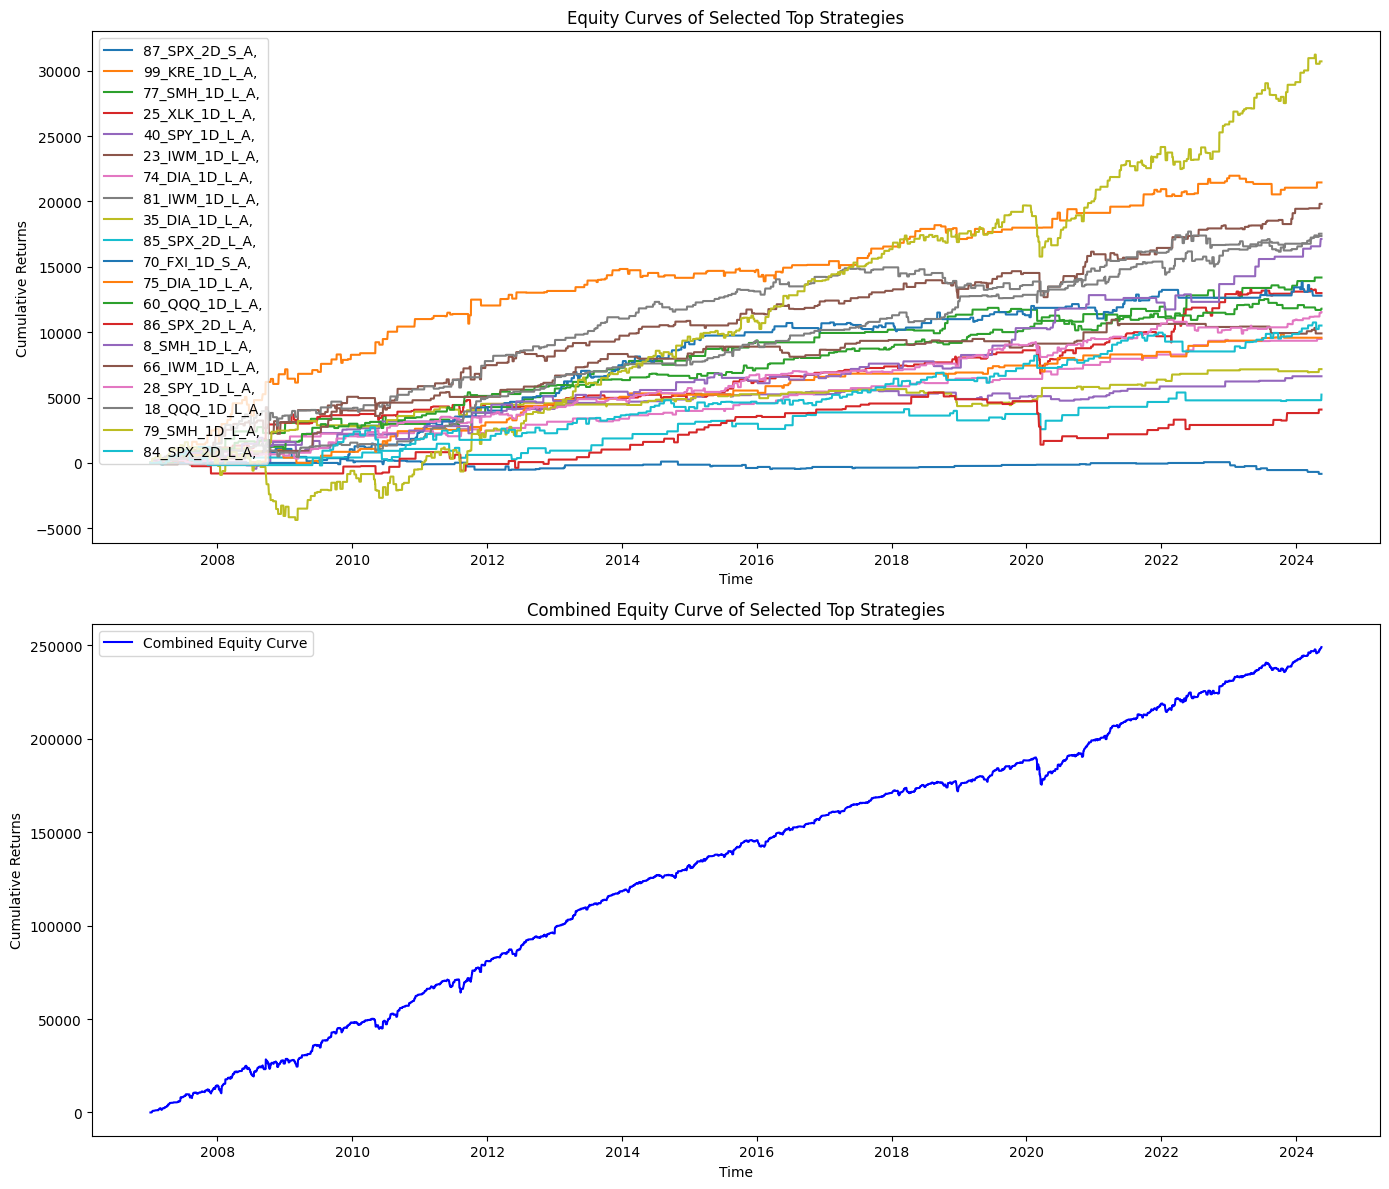

,NetProfit,MaxDD,PNL/DD,StdDev,Sharpe,Sortino,Corr_SPY,Corr_IWM,Corr_EEM,Corr_TLT,Corr_GLD,Corr_VEA,Corr_LQD,Corr_QQQ,Corr_EFA,Corr_^VIX,Cluster,Cluster_PCA
"87_SPX_2D_S_A,",-835.55,1905.55,-0.438482,154.525978,-0.068445,-0.082736,-0.080152,0.024538,-0.006851,0.040941,0.058826,0.028049,0.030715,-0.115778,0.241866,0.247328,17,0
"99_KRE_1D_L_A,",21454.32,1431.04,14.992118,399.548829,0.323472,0.512934,0.054480,-0.110796,0.105335,0.016408,-0.035101,0.035241,-0.009621,0.015468,0.087660,-0.055871,7,1
"77_SMH_1D_L_A,",14182.09,1058.37,13.399936,369.079838,0.400266,0.651239,-0.119898,0.032823,0.121139,0.041213,0.247601,0.079657,-0.015069,-0.058845,-0.076914,-0.046195,9,2
"25_XLK_1D_L_A,",12990.44,2031.42,6.394758,271.227227,0.226991,0.284294,0.017643,0.069753,0.082440,0.071592,-0.060090,0.142209,0.042448,0.111163,0.142925,-0.013081,0,3
"40_SPY_1D_L_A,",6627.97,909.71,7.285805,230.724861,0.341985,0.661519,0.003540,0.214675,-0.239400,-0.023642,-0.031747,0.046889,-0.234404,-0.027349,-0.121274,-0.018047,18,4
"23_IWM_1D_L_A,",19817.48,2031.11,9.75697,375.98851,0.273097,0.378849,0.144358,-0.029134,-0.043594,0.076903,-0.092089,-0.071166,-0.079849,0.048692,-0.054755,0.047819,6,5
"74_DIA_1D_L_A,",9483.8,394.7,24.027869,195.269483,0.578188,1.184317,0.089767,0.112538,-0.169844,0.148129,0.014554,-0.077019,-0.054252,0.144251,0.190495,-0.133650,13,6
"81_IWM_1D_L_A,",17359.07,2146.05,8.088847,277.25133,0.259798,0.333623,0.139615,0.075378,-0.022854,-0.024038,0.045299,0.024789,0.017798,-0.051143,0.049150,-0.068790,2,7
"35_DIA_1D_L_A,",7174.33,1305.07,5.497276,225.159649,0.306378,0.661963,-0.024705,0.098223,-0.040361,0.111738,0.094386,0.064651,-0.018375,0.095109,0.077247,0.131897,19,8
"85_SPX_2D_L_A,",5224.83,1534.49,3.404929,409.936047,0.21975,0.303615,-0.016152,-0.132410,0.032586,-0.224911,0.078833,0.177117,0.079513,-0.043030,0.140396,0.257591,11,9


In [40]:
# function to select the top strategy by a given metric from each cluster and plot individual and combined equity curves
def select_top_strategies_and_plot_combined(returns, metrics_df, metric='Sharpe', cluster_col='Cluster_PCA'):
    top_strategies = metrics_df.loc[metrics_df.groupby(cluster_col)[metric].idxmax()]
    
    plt.figure(figsize=(14, 12))
    
    # Plot individual equity curves
    plt.subplot(2, 1, 1)
    for strategy in top_strategies.index:
        equity_curve = returns[strategy].copy()
        equity_curve.index = equity_curve.index.to_timestamp()  # Convert PeriodIndex to Timestamp
        equity_curve = equity_curve.cumsum()
        plt.plot(equity_curve, label=strategy)
    
    plt.title('Equity Curves of Selected Top Strategies')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='upper left')
    
    # Calculate and plot combined equity curve
    combined_equity_curve = returns[top_strategies.index].sum(axis=1)
    combined_equity_curve.index = combined_equity_curve.index.to_timestamp()  # Convert PeriodIndex to Timestamp
    combined_equity_curve = combined_equity_curve.cumsum()
    
    plt.subplot(2, 1, 2)
    plt.plot(combined_equity_curve, label='Combined Equity Curve', color='blue')
    
    plt.title('Combined Equity Curve of Selected Top Strategies')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return top_strategies, combined_equity_curve

# Select top strategies based on Sortino ratio from PCA clustering and plot the combined equity curve
top_strategies_pca, combined_equity_curve = select_top_strategies_and_plot_combined(returns, metrics_df, metric='Sharpe', cluster_col='Cluster_PCA')
top_strategies_pca


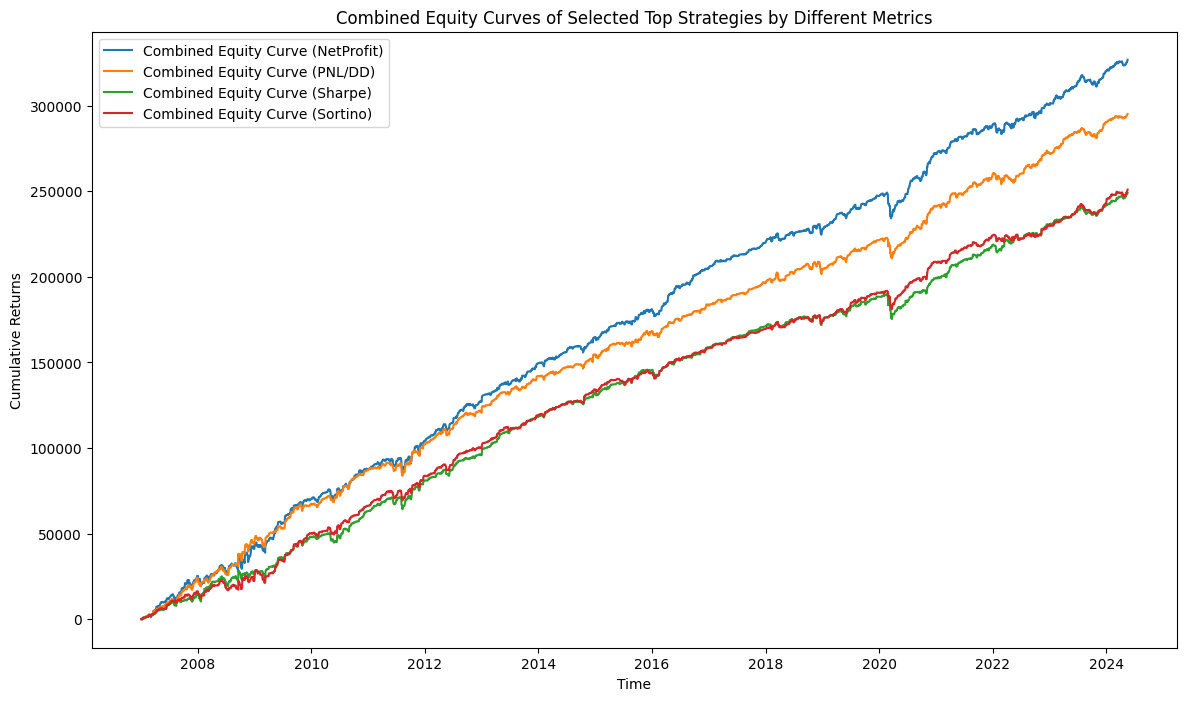

In [41]:
# function to select the top strategy by a given metric from each cluster and plot combined equity curves for multiple metrics
def plot_combined_equity_curves(returns, metrics_df, cluster_col='Cluster_PCA', metrics=['NetProfit', 'PNL/DD', 'Sharpe', 'Sortino']):
    combined_curves = {}
    
    for metric in metrics:
        top_strategies = metrics_df.loc[metrics_df.groupby(cluster_col)[metric].idxmax()]
        combined_equity_curve = returns[top_strategies.index].sum(axis=1)
        combined_equity_curve.index = combined_equity_curve.index.to_timestamp()  # Convert PeriodIndex to Timestamp
        combined_equity_curve = combined_equity_curve.cumsum()
        combined_curves[metric] = combined_equity_curve
    
    plt.figure(figsize=(14, 8))
    
    for metric, equity_curve in combined_curves.items():
        plt.plot(equity_curve, label=f'Combined Equity Curve ({metric})')
    
    plt.title('Combined Equity Curves of Selected Top Strategies by Different Metrics')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='upper left')
    plt.show()

# plot combined equity curves for different metrics
plot_combined_equity_curves(returns, metrics_df, cluster_col='Cluster_PCA', metrics=['NetProfit', 'PNL/DD', 'Sharpe', 'Sortino', ])
